In [ ]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, BasicAer, execute
from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import pandas as pd

# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [ ]:
# bruteforce search.py
import numpy as np

class BinarySequenceIter:
    def __init__(self, n):
        self.n = n
        self.value = np.zeros(n)
        self.at_end = False
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.at_end:
            raise StopIteration
        prev_value = self.value.copy()
        j = self.n - 1
        while j >= 0 and self.value[j] == 1:
            self.value[j] = 0
            j -= 1
        if j >= 0:
            self.value[j] = 1
        else:
            self.at_end = True
        return prev_value

class CombinationSelectorIter:
    def __init__(self, n, k):
        self.n = n
        self.k = k
        self.value = np.arange(k)
        self.at_end = False
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.value[-1] >= self.n or self.at_end:
            raise StopIteration
        prev_value = np.copy(self.value)
        j = self.k - 1
        while self.value[j] == self.n - 1 - (self.k - 1 - j):
            j -= 1
        if j < 0:
            self.at_end = True
        else:
            self.value[j] += 1
            for l in range(j + 1, self.k):
                self.value[l] = self.value[j] + l - j
        return prev_value

# graph.py    
import random

def random_d_regular_graph(n, d):
    while True:
        U = set(range(n * d))
        graph = {} 
        while len(U):
            j, k = random.sample(U, 2)
            U.remove(j)
            U.remove(k)
            if int(j / d) == int(k / d):
                break
            if not int(j / d) in graph:
                graph[int(j / d)] = []
            if not int(k / d) in graph:
                graph[int(k / d)] = []
            graph[int(j / d)].append(int(k / d))
            graph[int(k / d)].append(int(j / d))
        if len(graph) == n and all([ len(set(graph[v])) == d and v not in graph[v] for v in graph ]):
            return graph
    
    
# random ising

def random_max_cut_ising(n):
    if n % 1:
        raise Exception("number of vertices must be even")
    g = random_d_regular_graph(n, 3)
    edges = {}
    for v in g:
        for adj_v in g[v]:
            if v < adj_v:
                edges[(v, adj_v)] = 1
    return edges

In [ ]:
### Parameters

n = 6 # Number of vertices

### Main program

edges = random_max_cut_ising(n)
energies = []

# Iterate over the 2^n possible sequences of n bits. Bit k in the sequence represents the state of the k-th qubit.

for seq in BinarySequenceIter(n):
    # Compute and save the energy corresponding to the configuration described by the sequence.
    energy = 0
    for edge, J in edges.items():
        energy += J * (1 if seq[edge[0]] == seq[edge[1]] else -1)
    energies.append(energy)
    key = ''.join([str(int(i)) for i in seq])
    
import matplotlib.pyplot as plt
 
plt.hist(energies)
print(edges)

In [ ]:
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.providers.aer import noise

# circuit size
N = 6

# Choose a real device to simulate
IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
device = provider.get_backend('ibmq_16_melbourne')
properties = device.properties()
coupling_map = device.configuration().coupling_map

# Generate an Aer noise model for device
noise_model = noise.device.basic_device_noise_model(properties)
basis_gates = noise_model.basis_gates

edges = random_max_cut_ising(N)

def generate_circuit(n=N, 
                     steps=N, 
                     t=2.0*np.pi*0.5):
    coin_qr = QuantumRegister(n)
    pos_qr = QuantumRegister(n)
    pos_cr = ClassicalRegister(n)
    qc = QuantumCircuit(coin_qr, pos_qr, pos_cr)

    def hadamard(qc):
        for k in range(n):
            qc.h(coin_qr[k])
            #qc.ry(np.pi / 4, coin_qr[k])
            qc.cx(coin_qr[k], pos_qr[k])

    def ising(qc):
        for (i, j), J in edges.items():
            #print(i, j, J)
            qc.cx(pos_qr[i], pos_qr[j])
            qc.rz(t * J, pos_qr[i])
            qc.cx(pos_qr[i], pos_qr[j])
    
    # steps
    for step in range(steps):
        hadamard(qc)
        ising(qc)
        
    qc.measure(pos_qr, pos_cr)
    return qc

qc = generate_circuit()
# Perform noisy simulation
backend = Aer.get_backend('qasm_simulator')

do_noise = True
shots = 10000

if do_noise:
    job_sim = execute(qc, backend,
                  coupling_map=coupling_map,
                  noise_model=noise_model,
                  basis_gates=basis_gates,
                  shots=shots)
else:
    job_sim = execute(qc, backend, shots=shots)

sim_result = job_sim.result()
counts = sim_result.get_counts(qc)

print(counts)
# Plot a histogram
#print(qc.draw(output='text'))
plot_histogram(counts)

# compute classical energies
energies = {}
for seq in BinarySequenceIter(n):
    # Compute and save the energy corresponding to the configuration described by the sequence.
    energy = 0
    for edge, J in edges.items():
        energy += J * (1 if seq[edge[0]] == seq[edge[1]] else -1)
    key = ''.join([str(int(i)) for i in seq])
    energies[key] = energy    
    print(seq, energy, counts.get(key, 0))

df = pd.DataFrame({'counts': counts, 'energies': energies})
df.plot.scatter(y='counts', x='energies')
loss = -(df[df['energies']==df['energies'].min()])['counts'].sum() / df['counts'].sum()
print(loss, counts)

In [ ]:
def to_minimize(edges, ts, n):
    def generate_circuit(ts,
                         n=n, 
                         ):
        steps = len(ts) 
        coin_qr = QuantumRegister(n)
        pos_qr = QuantumRegister(n)
        pos_cr = ClassicalRegister(n)
        qc = QuantumCircuit(coin_qr, pos_qr, pos_cr)

        def hadamard(qc):
            for k in range(n):
                qc.h(coin_qr[k])
                #qc.ry(np.pi / 4, coin_qr[k])
                qc.cx(coin_qr[k], pos_qr[k])

        def ising(qc, t):
            for (i, j), J in edges.items():
                #print(i, j, J)
                qc.cx(pos_qr[i], pos_qr[j])
                qc.rz(2.0*np.pi*t * J, pos_qr[i])
                qc.cx(pos_qr[i], pos_qr[j])

        # steps
        #print(ts)
        for t in ts:
            hadamard(qc)
            ising(qc, t)

        qc.measure(pos_qr, pos_cr)
        return qc

    qc = generate_circuit(ts=ts)
    # Perform noisy simulation
    backend = Aer.get_backend('qasm_simulator')
    #backend = provider.get_backend('ibmq_16_melbourne')
    do_noise = True
    shots = 10000

    if do_noise:
        job_sim = execute(qc, backend,
                      coupling_map=coupling_map,
                      noise_model=noise_model,
                      basis_gates=basis_gates,
                      shots=shots)
    else:
        job_sim = execute(qc, backend, shots=shots)

    sim_result = job_sim.result()
    counts = sim_result.get_counts(qc)

    #print(counts)
    # Plot a histogram
    #print(qc.draw(output='text'))
    #plot_histogram(counts)

    # compute classical energies
    energies = {}
    for seq in BinarySequenceIter(n):
        # Compute and save the energy corresponding to the configuration described by the sequence.
        energy = 0
        for edge, J in edges.items():
            energy += J * (1 if seq[edge[0]] == seq[edge[1]] else -1)
        key = ''.join([str(int(i)) for i in seq])
        energies[key] = energy    
        #print(seq, energy, counts.get(key, 0))

    df = pd.DataFrame({'counts': counts, 'energies': energies})
    #df.plot.scatter(y='counts', x='energies')
    loss = -(df[df['energies']==df['energies'].min()])['counts'].sum() / df['counts'].sum()
    return loss

def batch_to_minimize(ts, n):
    return np.mean([to_minimize(random_max_cut_ising(n), ts, n) for c in range(10)])

t0s = np.linspace(0.05, 0.75, 50)
losses = []
for t0 in t0s:
    ts = [t0]*6
    loss = batch_to_minimize(ts, 6)
    print(t0, loss)
    losses.append(-loss)


In [ ]:
dff = pd.DataFrame({'Probability of minimum energy level': np.asarray(losses),
              'Hyperparameter t0 value': t0s})
dff.plot.scatter(y='Probability of minimum energy level',
                 x='Hyperparameter t0 value')

In [251]:
import matplotlib 
matplotlib.rc('xlabel', labelsize=20) 
matplotlib.rc('ylabel', labelsize=20) 
plt.figure(figsize=(20,10))
plt.plot(t0s, losses)
plt.ylabel('Probability to sample minimum energy level')
plt.xlabel('Hyperparameter \"t0\"');


KeyError: 'Unrecognized key "xlabel.labelsize" for group "xlabel" and name "labelsize"'

In [232]:
energies = {}
for seq in BinarySequenceIter(n):
    # Compute and save the energy corresponding to the configuration described by the sequence.
    energy = 0
    for edge, J in edges.items():
        energy += J * (1 if seq[edge[0]] == seq[edge[1]] else -1)
    key = ''.join([str(int(i)) for i in seq])
    energies[key] = energy    
    print(seq, energy, counts.get(key, 0))


[0. 0. 0. 0.] 6 0
[0. 0. 0. 1.] 0 0
[0. 0. 1. 0.] 0 0
[0. 0. 1. 1.] -2 0
[0. 1. 0. 0.] 0 0
[0. 1. 0. 1.] -2 0
[0. 1. 1. 0.] -2 0
[0. 1. 1. 1.] 0 0
[1. 0. 0. 0.] 0 0
[1. 0. 0. 1.] -2 0
[1. 0. 1. 0.] -2 0
[1. 0. 1. 1.] 0 0
[1. 1. 0. 0.] -2 0
[1. 1. 0. 1.] 0 0
[1. 1. 1. 0.] 0 0
[1. 1. 1. 1.] 6 0


-0.1993

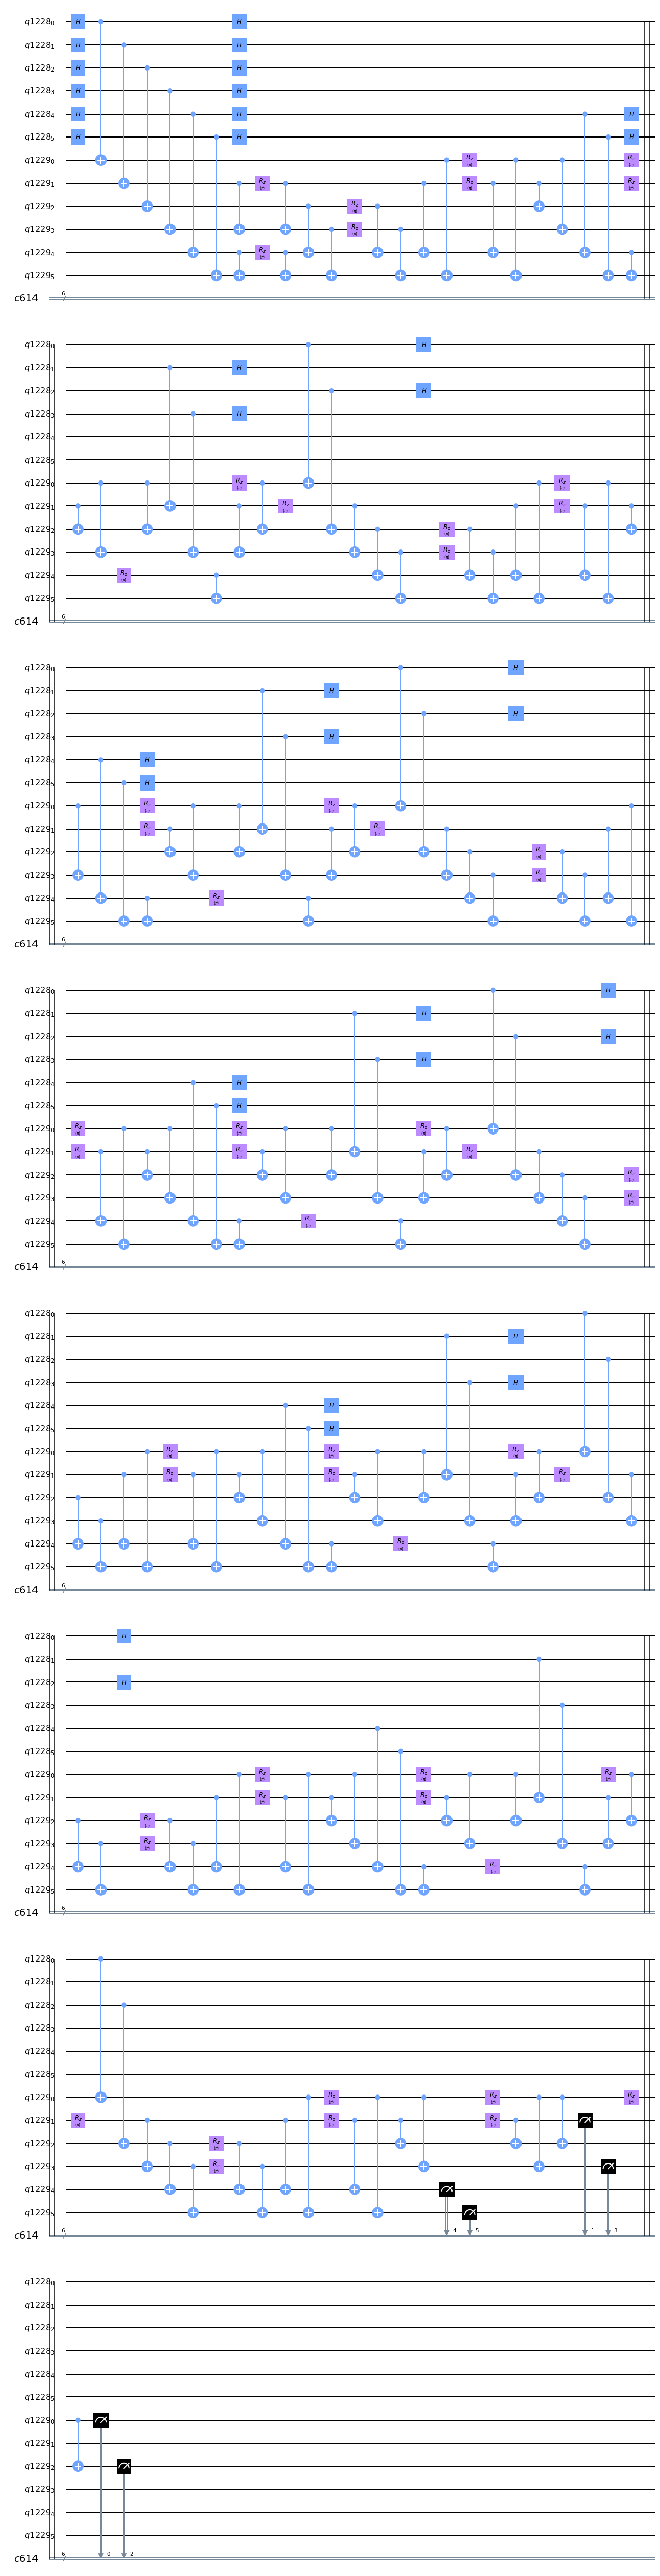

In [237]:
qc.draw(output='mpl')